순서1) 표 만들기(Matrix Factorization 구현) <br>
순서2) overfitting 발생을 확인할거임! <br>
      Matplotlib으로 epoch 마다 Training MSE 그리기 <br>
순서3) Matplotlib으로 epoch 마다 Test MSE 그리기 <br>
      Test MSE 그래프에서 학습이 진행될수록 MSE 값이 점점 증가함 - 오버피팅 확인 완료 <br>
순서4) 정규화(Regularization) 추가 <br>
      Training Data에 너무 매몰되지 않도록, latent vector가 너무 큰 값을 갖는  <br>
      (범위를 벗어나는) 경우 패널티 - 오버피팅 없어짐 <br>
순서5) bias 추가 - 더 학습이 잘됨 cost_test가 더 떨어짐 <br>
                  데이터가 부족해서 어떤 사람에겐 추천점수가 이상하게 나올 수 있음 - 대충 평균 비슷하게 주면 된다 <br>
                  bias도 학습해야 되는 값이니 학습해준다! <br>
                  너무 값이 하나로 튀면 오버피팅이 발생할 수 있으니 정규화 해준다. (lambda) <br>

In [59]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [60]:
# 일반적인 csv 파일은 콤마(,)로 구분되어 있지만 이번 데이터는 tab으로 구분됨.
train = pd.read_csv("./ml-100k/ua.base", sep="\t", names=["user", "item", "rating", "timestamp"])
test = pd.read_csv("./ml-100k/ua.test", sep="\t", names=["user", "item", "rating", "timestamp"])

In [61]:
# train datas
users = torch.tensor(train['user'], dtype=torch.long) # index이므로 long으로 받아온다
items = torch.tensor(train['item'], dtype=torch.long)
ratings = torch.tensor(train['rating'], dtype=torch.float)

# test datas
users_test = torch.tensor(test['user'], dtype=torch.long) # index이므로 long으로 받아온다
items_test = torch.tensor(test['item'], dtype=torch.long)
ratings_test = torch.tensor(test['rating'], dtype=torch.float)

epoch: 0, cost: 23.90810203552246, cost_test: 21.76848602294922
epoch: 100, cost: 0.5637184381484985, cost_test: 1.5077887773513794
epoch: 200, cost: 0.4924852252006531, cost_test: 1.9896352291107178
epoch: 300, cost: 0.4693026542663574, cost_test: 2.4080727100372314
epoch: 400, cost: 0.4591144919395447, cost_test: 2.788236141204834
epoch: 500, cost: 0.45350927114486694, cost_test: 3.159550666809082
epoch: 600, cost: 0.4499724805355072, cost_test: 3.5658507347106934
epoch: 700, cost: 0.4474705755710602, cost_test: 3.9514482021331787
epoch: 800, cost: 0.44560205936431885, cost_test: 4.309354305267334
epoch: 900, cost: 0.44416576623916626, cost_test: 4.737433910369873


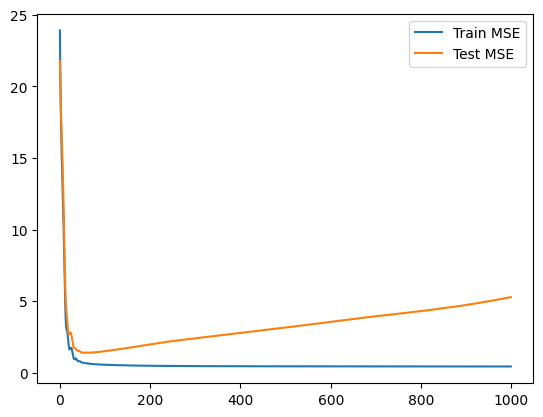

In [62]:
# 순서1) 표 만들기(Matrix Factorization 구현)
# 순서2) overfitting 발생을 확인할거임!

rank = 10

numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

optim = torch.optim.Adam([P, Q], lr=0.1)

X = [] # matplotlib를 이용하여 그래프를 그리기 위해 추가
Y = [] # matplotlib를 이용하여 그래프를 그리기 위해 추가
Y_test = []

for epoch in range(1000):
    h = (P[items] * Q[users]).sum(dim=1)
    cost = F.mse_loss(h, ratings)

    optim.zero_grad()
    cost.backward()
    optim.step()

    with torch.no_grad():

        X.append(epoch) # matplotlib를 이용하여 그래프를 그리기 위해 추가
        Y.append(cost.item())

        h_test = (P[items_test] * Q[users_test]).sum(dim=1)
        cost_test = F.mse_loss(h_test, ratings_test)
        Y_test.append(cost_test.item())

        if epoch % 100 == 0:
            print(f"epoch: {epoch}, cost: {cost.item()}, cost_test: {cost_test.item()}")

plt.plot(X, Y, label="Train MSE")
plt.plot(X, Y_test, label="Test MSE")
plt.legend()
plt.show()

epoch: 0, cost: 23.484397888183594, cost_test: 21.489395141601562
epoch: 100, cost: 0.6584192514419556, cost_test: 1.023923397064209
epoch: 200, cost: 0.6065874099731445, cost_test: 1.0195612907409668
epoch: 300, cost: 0.594845175743103, cost_test: 1.0199713706970215
epoch: 400, cost: 0.5904516577720642, cost_test: 1.0204271078109741
epoch: 500, cost: 0.58894944190979, cost_test: 1.0202988386154175
epoch: 600, cost: 0.5883721709251404, cost_test: 1.0201618671417236
epoch: 700, cost: 0.5881027579307556, cost_test: 1.0198969841003418
epoch: 800, cost: 0.587959349155426, cost_test: 1.0193612575531006
epoch: 900, cost: 0.5878779888153076, cost_test: 1.0186718702316284


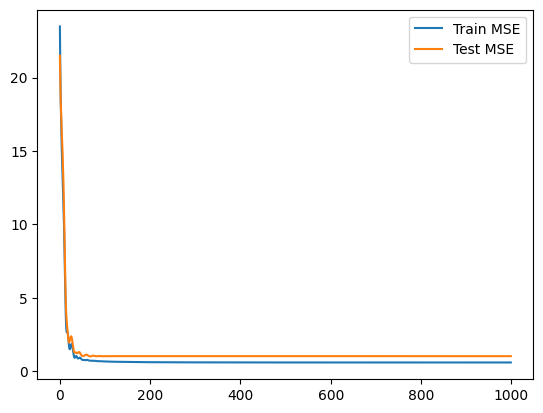

In [63]:
# 순서4) 정규화(Regularization) 추가
#      Training Data에 너무 매몰되지 않도록, latent vector가 너무 큰 값을 갖는 
#      (범위를 벗어나는) 경우 패널티 - 오버피팅 없어짐
rank = 10

numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 1 # 추가
lambda2 = 1 # 추가

optim = torch.optim.Adam([P, Q], lr=0.1)

X = []
Y = [] 
Y_test = []

for epoch in range(1000):
    h = (P[items] * Q[users]).sum(dim=1)
    cost = F.mse_loss(h, ratings)
    loss = cost + lambda1 * (P * P).mean() + lambda2 * (Q * Q).mean() # 추가

    optim.zero_grad()
    loss.backward() # 변경 cost -> loss
    optim.step()

    with torch.no_grad():

        X.append(epoch)
        Y.append(cost.item())

        h_test = (P[items_test] * Q[users_test]).sum(dim=1)
        cost_test = F.mse_loss(h_test, ratings_test)
        Y_test.append(cost_test.item())

        if epoch % 100 == 0:
            print(f"epoch: {epoch}, cost: {cost.item()}, cost_test: {cost_test.item()}")

plt.plot(X, Y, label="Train MSE")
plt.plot(X, Y_test, label="Test MSE")
plt.legend()
plt.show()

epoch: 0, cost: 23.530672073364258, cost_test: 21.85665512084961
epoch: 100, cost: 0.7247182726860046, cost_test: 1.0916497707366943
epoch: 200, cost: 0.6705232262611389, cost_test: 1.0910685062408447
epoch: 300, cost: 0.6573777794837952, cost_test: 1.088838815689087
epoch: 400, cost: 0.6526969075202942, cost_test: 1.0845534801483154
epoch: 500, cost: 0.6508235335350037, cost_test: 1.0806456804275513
epoch: 600, cost: 0.6498271226882935, cost_test: 1.0792080163955688
epoch: 700, cost: 0.6493221521377563, cost_test: 1.0791513919830322
epoch: 800, cost: 0.6491222977638245, cost_test: 1.0794434547424316
epoch: 900, cost: 0.6490597128868103, cost_test: 1.0797301530838013


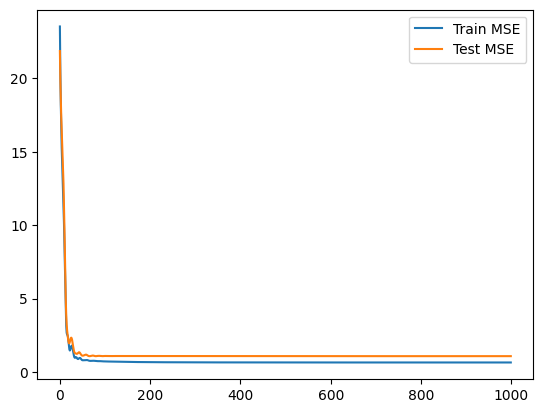

In [64]:
# 순서4) 정규화(Regularization) 추가
#      Training Data에 너무 매몰되지 않도록, latent vector가 너무 큰 값을 갖는 
#      (범위를 벗어나는) 경우 패널티 - 오버피팅 없어짐
rank = 10

numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 1 # 추가
lambda2 = 2 # 추가

optim = torch.optim.Adam([P, Q], lr=0.1)

X = []
Y = [] 
Y_test = []

for epoch in range(1000):
    h = (P[items] * Q[users]).sum(dim=1)
    cost = F.mse_loss(h, ratings)
    loss = cost + lambda1 * (P * P).mean() + lambda2 * (Q * Q).mean() # 추가

    optim.zero_grad()
    loss.backward() # 변경 cost -> loss
    optim.step()

    with torch.no_grad():

        X.append(epoch)
        Y.append(cost.item())

        h_test = (P[items_test] * Q[users_test]).sum(dim=1)
        cost_test = F.mse_loss(h_test, ratings_test)
        Y_test.append(cost_test.item())

        if epoch % 100 == 0:
            print(f"epoch: {epoch}, cost: {cost.item()}, cost_test: {cost_test.item()}")

plt.plot(X, Y, label="Train MSE")
plt.plot(X, Y_test, label="Test MSE")
plt.legend()
plt.show()

epoch: 0, cost: 12.775411605834961, cost_test: 9.94658374786377
epoch: 100, cost: 0.6054480671882629, cost_test: 0.9329254031181335
epoch: 200, cost: 0.5784652829170227, cost_test: 0.9204469323158264
epoch: 300, cost: 0.5748546719551086, cost_test: 0.9178927540779114
epoch: 400, cost: 0.5733044147491455, cost_test: 0.9163293838500977
epoch: 500, cost: 0.5723552703857422, cost_test: 0.9141626358032227
epoch: 600, cost: 0.5718353390693665, cost_test: 0.9123316407203674
epoch: 700, cost: 0.5716449022293091, cost_test: 0.911303699016571
epoch: 800, cost: 0.5715332627296448, cost_test: 0.910767138004303
epoch: 900, cost: 0.5714167952537537, cost_test: 0.9105959534645081


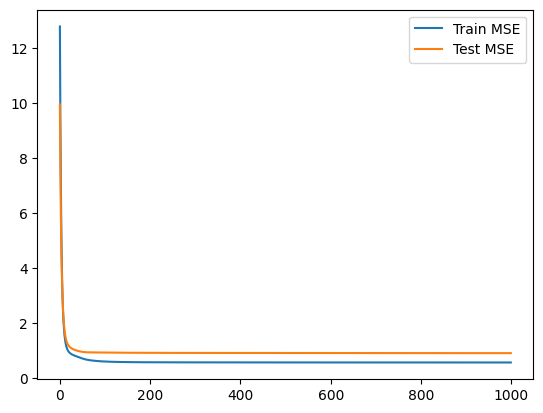

In [68]:
# 순서5) bias 추가 - 더 학습이 잘됨 cost_test가 더 떨어짐
#                  데이터가 부족해서 어떤 사람에겐 추천점수가 이상하게 나올 수 있음 - 대충 평균 비슷하게 주면 된다
#                  bias도 학습해야 되는 값이니 학습해준다!
#                  너무 값이 하나로 튀면 오버피팅이 발생할 수 있으니 정규화 해준다. (lambda)
rank = 10

numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

bias_users = torch.randn(numUsers, requires_grad=True) # 추가
bias_items = torch.randn(numItems, requires_grad=True) # 추가
mean = ratings.mean() # 추가

lambda1 = 1 
lambda2 = 1

lambda3 = 1 # 추가
lambda4 = 1 # 추가

optim = torch.optim.Adam([P, Q, bias_users, bias_items], lr=0.1) # 추가

X = []
Y = [] 
Y_test = []

for epoch in range(1000):
    h = (P[items] * Q[users]).sum(dim=1) + mean + bias_users[users] + bias_items[items] # 변경
    cost = F.mse_loss(h, ratings)
    loss = cost + lambda1 * (P * P).mean() + lambda2 * (Q * Q).mean() + lambda3 * (bias_users ** 2).mean() + lambda4 * (bias_items ** 2).mean() # 추가

    optim.zero_grad()
    loss.backward()
    optim.step()

    with torch.no_grad():

        X.append(epoch)
        Y.append(cost.item())

        h_test = (P[items_test] * Q[users_test]).sum(dim=1) + mean + bias_users[users_test] + bias_items[items_test] # 변경
        cost_test = F.mse_loss(h_test, ratings_test)
        Y_test.append(cost_test.item())

        if epoch % 100 == 0:
            print(f"epoch: {epoch}, cost: {cost.item()}, cost_test: {cost_test.item()}")

plt.plot(X, Y, label="Train MSE")
plt.plot(X, Y_test, label="Test MSE")
plt.legend()
plt.show()